## 프로젝트 1-1.

* (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
* 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
* 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
* 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.
* 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
* 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

### 이미지 불러오기

(675, 1200, 3)
(1200, 672)


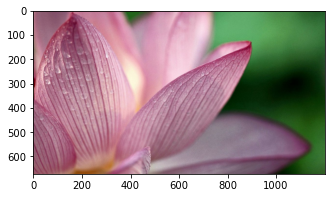

In [1]:
from skimage import data
import matplotlib.pyplot as plt
import os
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


data_path = os.getenv('HOME')+'/aiffel/super_resolution/003.jpg'
hr_image_BGR = cv2.imread(data_path) # skimage에서 제공하는 예제 이미지를 불러옵니다.
hr_image = cv2.cvtColor(hr_image_BGR, cv2.COLOR_BGR2RGB)
hr_image
print(hr_image.shape) # (세로 픽셀 수, 가로 픽셀 수)

# hr_shape = hr_image.shape[:2]
size = (hr_image.shape[1]-hr_image.shape[1]%4, hr_image.shape[0]-hr_image.shape[0]%4)
print(size)
hr_image = cv2.resize(hr_image, dsize = (size))
plt.figure(figsize=(6,3))
plt.imshow(hr_image)

In [2]:
# class interpolation:
#     def __init__(self, image, n):
#         self.hr_shape = image.shape
#         self.image = image
#         self.n = n
    
    
#     def downsampling(self):
        

#         downsampling = cv2.resize(
#             self.image,
#             dsize = (self.hr_shape[1]//n, self.hr_shape[0]//n), # 가로 픽셀 수, 세로 픽셀 수
#             interpolation = cv2.INTER_CUBIC
#         )
#         return downsampling
    
#     def upsampling(self):
#         upsampling = cv2.resize(
#             downsampling,
#             dsize = (hr_shape[1], hr_shape[0]),
#             interpolation = cv2.INTER_CUBIC
#         )
#         return upsampling

# bicubic_image = interpolation(hr_image,4)
# plt.imshow(bicubic_image)

In [3]:
# images = [bicubic_image, hr_image]
# titles = ["Bicubic", "HR"]

# plt.figure(figsize=(16,3))
# for i, (image, title) in enumerate(zip(images, titles)):
#     plt.subplot(1,3,i+1)
#     plt.imshow(image)
#     plt.title(title, fontsize=20)

In [4]:
# # 특정 영역을 잘라낼 함수를 정의합니다.
# def crop(image, left_top, x=50, y=100):
#     return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# # 잘라낼 영역의 좌표를 정의합니다.
# left_tops = [(50,350)] *2 + [(200,350)] *2 + [(30,200)] *2
# print(left_tops)

# plt.figure(figsize=(16,10))
# for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
#     plt.subplot(3,2,i+1)
#     plt.imshow(crop(image, left_top))
#     plt.title(title, fontsize=20)

#### 전이학습

In [5]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

## 16-9.

### SRGAN 구현하기
1. Generator
2. Discriminator

### Generator

In [6]:
from tensorflow.keras import Input, Model

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

✅


### Discriminator

In [7]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

✅


#### SRGAN 학습하기(loss값 계산)
VGG19를 이용해 content loss를 계산


In [8]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

print("✅")

✅


### SRGAN 테스트하기
SRGAN은 크게 두 개의 신경망(Generator, Discriminator)으로 구성되어 있지만, 테스트에는 저해상도 입력을 넣어 고해상도 이미지를 출력하는 Generator만 이용

#### 학습된 Generator 불러오기

In [9]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

#### 테스트 과정을 진행하는 함수 정의

SRGAN의 고해상도 결과를 생성

#### 데이터 준비하기
SRCNN은 저해상도 이미지에 대해 interpolation하여 고해상도 이미지 크기로 맞춘 후 입력으로 사용했지만, SRGAN은 그러한 과정을 거치지 않습니다.

#### 다운샘플링

168


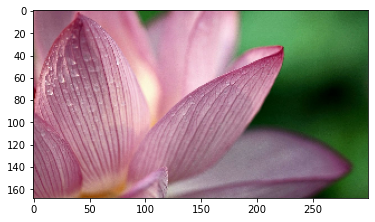

In [10]:
hr_shape = hr_image.shape

print(hr_shape[0]//4)
lr = cv2.resize(
        hr_image,
        dsize = (hr_shape[1]//4, hr_shape[0]//4), # 가로 픽셀 수, 세로 픽셀 수
        interpolation = cv2.INTER_CUBIC)
plt.imshow(lr)

#### 업샘플링

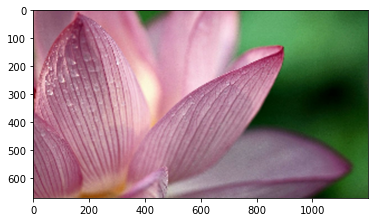

In [11]:
bicubic_hr = cv2.resize(
        lr,
        dsize = (hr_shape[1], hr_shape[0]),
        interpolation = cv2.INTER_CUBIC)
plt.imshow(bicubic_hr)

#### SRGAN 이미지 생성

✅


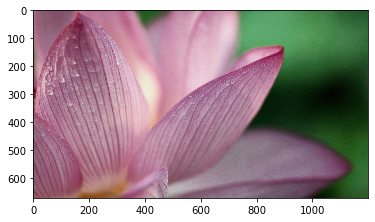

In [12]:
import numpy as np
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)# array의 차원을 늘려줌
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)# min보다 작은건 min으로, max보다 큰건 max로
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr = apply_srgan(lr)
# srgan_hr = cv2.resize(srgan_hr, dsize=(825, 510))
print("✅")
plt.imshow(srgan_hr)

### Super Resolution 결과 평가하기


#### PSNR과 SSIM(높을수록 좋음)
* PSNR(Peak Signal-to-Noise Ratio)은 영상 내 신호가 가질 수 있는 최대 신호에 대한 잡음(noise)의 비율
  * 영상을 압축했을 때 화질이 얼마나 손실되었는지 평가하는 목적으로 사용
* SSIM(Structural Similarity Index Map)은 영상의 구조 정보를 고려하여 얼마나 구조 정보를 변화시키지 않았는지를 계산
  * 특정 영상에 대한 SSIM값이 높을수록 원본 영상의 품질에 가깝다는 의미

#### 해상도에 따른 복원시 수치 비교

#### Super Resolution 결과와 원래 고해상도 이미지 사이의 PSNR, SSIM을 계산

In [13]:
print(bicubic_hr.shape, srgan_hr.shape, hr_image.shape)

(672, 1200, 3) (672, 1200, 3) (672, 1200, 3)


/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


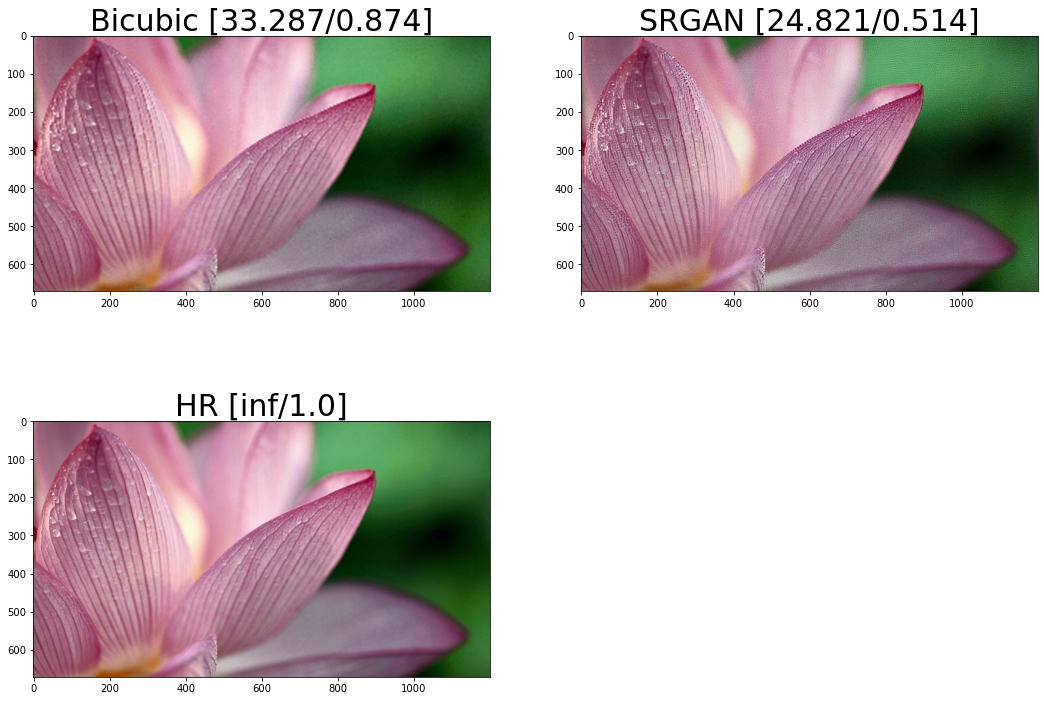

In [14]:
images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(hr_image, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(hr_image, i, multichannel=True), 3) for i in images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(18,13))
for i in range(3):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

#### 시각적으로 가장 고해상도 이미지에 가까웠던 SRGAN의 PSNR과 SSIM 수치가 다른 방법들에 비해 낮음
* SRCNN의 학습에 Mean Squared Error를 사용했기 때문에, 생성해야 할 픽셀 값들을 고해상도 이미지와 비교해 단순히 평균적으로 잘 맞추는 방향으로 예측했기 때문


* SRGAN의 경우 Generator가 고해상도 이미지를 생성하는 과정에서 Discriminator를 속이기 위해 이미지를 진짜 같이 선명하게 만들도록 학습 되었기 때문
* VGG구조를 이용한 content loss를 통해 학습한 것 또한 사실적인 이미지를 형성하는데 크게 기여
* 입력되었던 저해상도 이미지가 매우 제한된 정보를 가지고 있기에 고해상도 이미지와 세부적으로 동일한 모양으로 선명하지 않아 점수가 낮음

In [15]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]



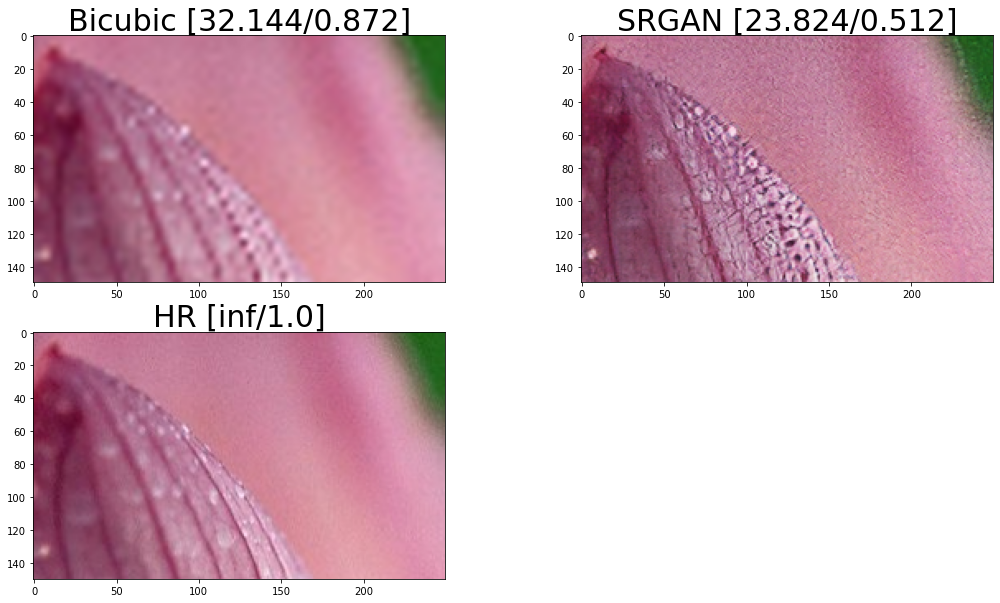

In [16]:
left_top = (0, 150)
crop_images = [crop(i, left_top, 150, 250) for i in images]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(18,10))
for i in range(3):
    plt.subplot(2,2,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

### 프로젝트 1-2.

* (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
* 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
* 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
* 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
* 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

### 이미지 불러오기

(308, 461, 3)


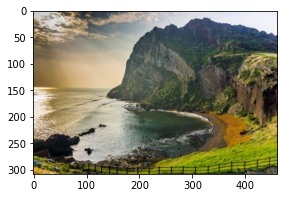

In [17]:
from skimage import data
import matplotlib.pyplot as plt
import os
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


data_path = os.getenv('HOME')+'/aiffel/super_resolution/low.jpg'
hr_image_BGR = cv2.imread(data_path) # skimage에서 제공하는 예제 이미지를 불러옵니다.
hr_image = cv2.cvtColor(hr_image_BGR, cv2.COLOR_BGR2RGB)
hr_image
print(hr_image.shape) # (세로 픽셀 수, 가로 픽셀 수)

hr_shape = hr_image.shape[:2]
# size = (hr_image.shape[1]-hr_image.shape[1]%4, hr_image.shape[0]-hr_image.shape[0]%4)
# print(size)
# hr_image = cv2.resize(hr_image, dsize = (size))
plt.figure(figsize=(6,3))
plt.imshow(hr_image)

#### 업샘플링

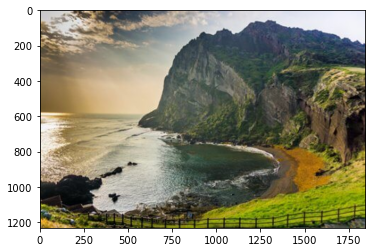

In [18]:
bicubic_hr = cv2.resize(
        hr_image,
        dsize = (hr_shape[1]*4, hr_shape[0]*4),
        interpolation = cv2.INTER_CUBIC)
plt.imshow(bicubic_hr)

#### 전이학습

In [19]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

## 16-9.

### SRGAN 구현하기
1. Generator
2. Discriminator

### Generator

In [20]:
from tensorflow.keras import Input, Model

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

✅


### Discriminator

In [21]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

✅


#### SRGAN 학습하기(loss값 계산)
VGG19를 이용해 content loss를 계산


In [22]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

print("✅")

✅


### SRGAN 테스트하기
SRGAN은 크게 두 개의 신경망(Generator, Discriminator)으로 구성되어 있지만, 테스트에는 저해상도 입력을 넣어 고해상도 이미지를 출력하는 Generator만 이용

#### 학습된 Generator 불러오기

In [23]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

#### 테스트 과정을 진행하는 함수 정의

SRGAN의 고해상도 결과를 생성

#### 데이터 준비하기
SRCNN은 저해상도 이미지에 대해 interpolation하여 고해상도 이미지 크기로 맞춘 후 입력으로 사용했지만, SRGAN은 그러한 과정을 거치지 않습니다.

#### SRGAN 이미지 생성

✅


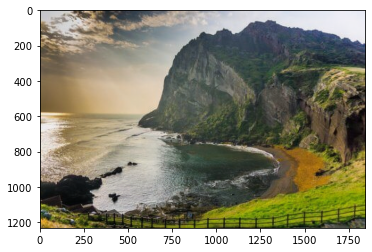

In [24]:
import numpy as np
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)# array의 차원을 늘려줌
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)# min보다 작은건 min으로, max보다 큰건 max로
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr = apply_srgan(hr_image)
# srgan_hr = cv2.resize(srgan_hr, dsize=(825, 510))
print("✅")
plt.imshow(srgan_hr)

### Super Resolution 결과 평가하기


#### PSNR과 SSIM(높을수록 좋음)
* PSNR(Peak Signal-to-Noise Ratio)은 영상 내 신호가 가질 수 있는 최대 신호에 대한 잡음(noise)의 비율
  * 영상을 압축했을 때 화질이 얼마나 손실되었는지 평가하는 목적으로 사용
* SSIM(Structural Similarity Index Map)은 영상의 구조 정보를 고려하여 얼마나 구조 정보를 변화시키지 않았는지를 계산
  * 특정 영상에 대한 SSIM값이 높을수록 원본 영상의 품질에 가깝다는 의미

#### 해상도에 따른 복원시 수치 비교

#### Super Resolution 결과와 원래 고해상도 이미지 사이의 PSNR, SSIM을 계산

In [25]:
print(bicubic_hr.shape, srgan_hr.shape)

(1232, 1844, 3) (1232, 1844, 3)


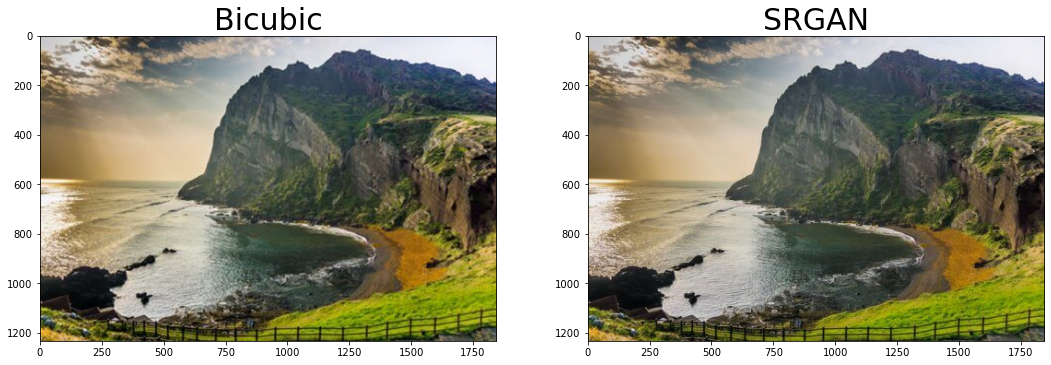

In [26]:
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(18,13))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i], fontsize=30)

#### 시각적으로 가장 고해상도 이미지에 가까웠던 SRGAN의 PSNR과 SSIM 수치가 다른 방법들에 비해 낮음
* SRCNN의 학습에 Mean Squared Error를 사용했기 때문에, 생성해야 할 픽셀 값들을 고해상도 이미지와 비교해 단순히 평균적으로 잘 맞추는 방향으로 예측했기 때문


* SRGAN의 경우 Generator가 고해상도 이미지를 생성하는 과정에서 Discriminator를 속이기 위해 이미지를 진짜 같이 선명하게 만들도록 학습 되었기 때문
* VGG구조를 이용한 content loss를 통해 학습한 것 또한 사실적인 이미지를 형성하는데 크게 기여
* 입력되었던 저해상도 이미지가 매우 제한된 정보를 가지고 있기에 고해상도 이미지와 세부적으로 동일한 모양으로 선명하지 않아 점수가 낮음

In [27]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]



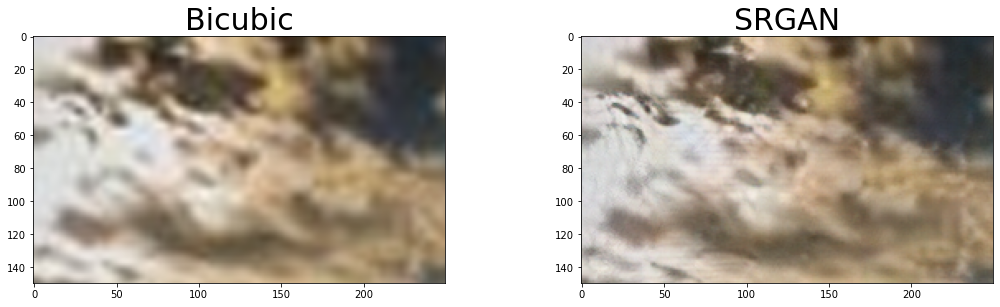

In [28]:
left_top = (0, 150)
crop_images = [crop(i, left_top, 150, 250) for i in images]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(18,10))
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i], fontsize=30)

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

* 이전 Super Resolution의 활용 사례에 대해 살펴봤을 때, 단일 이미지가 아닌 영상에 대해 Super Resolution을 적용한 사례가 있었습니다. 이번에는 이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행해 봅시다.


* 실제로 동영상의 Super Resolution은 시간 순서에 따른 다수의 프레임 정보를 고려하는 것이 더 좋지만, 처음부터 학습시키기에 많은 시간이 소요됩니다. 여기서는 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어 봅시다.


* 각 프레임들을 모아 gif 파일을 만드는데 아래 라이브러리의 설치가 필요합니다.

### 1. gif 파일 불러오기

In [29]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv("HOME")+'/aiffel/super_resolution/'
gif = cv2.VideoCapture(gif_path+"metro_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 35
frame 크기 : (252, 282, 3)


In [30]:
print(frames[0].shape[0])

252


In [31]:
size_1, size_0 = (frames[0].shape[1] - frames[0].shape[1]%4, frames[0].shape[0] - frames[0].shape[0]%4)


### 2. 프레임별 Super Resolution 진행하기
* Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣어주세요.

#### BICUBIC gif

In [32]:
frames_sr_bi = []
for i in range(len(frames)):
    a = cv2.resize(
        frames[i],
        dsize = (size_1*4, size_0*4),
        interpolation = cv2.INTER_CUBIC
    )
    frames_sr_bi.append(a)
print(frames_sr_bi[0].shape)

(1008, 1120, 3)


#### SRGAN gif

In [33]:
a = [1,2,3,4,5]
[a[i]*7 for i in range(len(a))]

[7, 14, 21, 28, 35]

In [34]:
frames_sr_gan = [apply_srgan(frames[i]) for i in range(len(frames))]
# srgan_hr = cv2.resize(srgan_hr, dsize=(825, 510))
print("✅")

✅


### 3. 프레임을 합쳐 gif 만들기
* 위에서 frame_sr을 만들었다면 아래 코드와 같이 gif 파일을 생성할 수 있습니다. Bicubic 및 SRGAN의 결과를 각각 저장하여 2개 파일을 만들어 주세요.

In [35]:
import imageio

imageio.mimsave(gif_path+"바이고해상도.gif", frames_sr_bi)

In [36]:
import imageio

imageio.mimsave(gif_path+"간고해상도.gif", frames_sr_gan)

### 4. Jupyter notebook에 gif 표시하기
* 아래와 같이 다운받은 저해상도 gif 파일과 고해상도 gif 파일을 각각 jupyter 내에 출력하여 최종 제출해 주시면 됩니다. jupyter 내에 출력이 어려운 경우, GitHub에 저해상도, 고해상도 gif파일을 업로드 후 링크를 첨부해주시기바랍니다. 
* Super Resolution이 잘 적용되었는지 시각적으로 확인하기 위해 아래의 width 옵션을 적당히 크게 해주세요. 저해상도 및 고해상도 시각화의 width 값은 같도록 설정해주세요.

In [48]:
# from IPython.display import Image as show_gif

# show_gif(gif_path+"metro_lr.gif", width=800) # width 는 적당히 큰 값으로 설정해주세요

In [49]:
# show_gif(gif_path+"바이고해상도.gif", width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

In [50]:
# show_gif(gif_path+"간고해상도.gif", width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요